In [1]:
"""Selección de Características para mapa UMAP Wavelet"""
import sys
import multiprocessing as mp
from copy import deepcopy
from itertools import product
import numpy as np
import config_dodo
import config
from utilities import read_pickle, write_pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.signal import savgol_filter, find_peaks
from scipy.stats import entropy
from matplotlib import cm
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from matplotlib.patches import Circle
import plotly.express as px
import plotly.graph_objects as go
import pylab
import scipy.cluster.hierarchy as spc
import scipy.spatial.distance as spd
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import butter, filtfilt
from scipy.signal import medfilt
from scipy.stats import trim_mean
import datashader.bundling as bd
from bundle_edges import hammer_connectivity, _get_embedding
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from fastkde import fastKDE
from skimage.filters import gaussian
import statsmodels.api as sm

(config_dodo.FIG_PATH / "Embeddings/Colors/Wavelets").mkdir(parents=True, exist_ok=True)
sns.set_context("paper", font_scale=2.0)
sns.set_style(
    "ticks",
    {
        "text.color": "k",
        "axes.edgecolor": "k",
        "axes.labelcolor": "k",
        "xtick.color": "k",
        "ytick.color": "k",
    },
)

/home/alvaro/.local/lib/python3.8/site-packages/xarray/core/merge.py:10: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [2]:
wav_sample_path = config_dodo.WAV_PATH / "wav_sample.pickle"
wav_sample = read_pickle(wav_sample_path)
pca_wav_sample_path = config_dodo.WAV_PATH / "pca_wav_sample.pickle"
pca_wav_sample = read_pickle(pca_wav_sample_path)
emb_wav_path = config_dodo.EMB_PATH / "emb_wav_sample.pickle"
emb_wav = read_pickle(emb_wav_path)
out_wav_path = config_dodo.OUT_PATH / "out_wav_sample.pickle"
out_wav = read_pickle(out_wav_path)
knn_wav_path = config_dodo.EMB_PATH / "knn_fit_wav.pickle"
knn_wav = read_pickle(knn_wav_path)
edg_wav_path = config_dodo.EMB_PATH / "edg_wav_sample.pickle"
edg_wav = read_pickle(edg_wav_path)
loc_dim_wav_path = config_dodo.EMB_PATH / "loc_dim_wav_sample.pickle"
loc_dim_wav = read_pickle(loc_dim_wav_path)
out_wav_all = read_pickle(config_dodo.OUT_PATH / "out_wav_all.pickle")
label_wav_all = read_pickle(config_dodo.LAB_PATH / "lab_wav_all.pickle")
label_stp_all = read_pickle(config_dodo.LAB_PATH / "lab_stp_all.pickle")

Thu Feb  3 14:51:27 2022 Building and compiling search function


In [3]:
sample_idx_stp = []
sample_idx_wav = []
lat_sum = 0
for key in config_dodo.KEY_LIST:
    name = config_dodo.SUBJECT_NAME.format(*key)
    pickle_end = name + ".pickle"
    idx = read_pickle(config_dodo.IDX_PATH / f"idx_{pickle_end}")
    sample_idx_stp.append(idx + lat_sum)
    sample_idx_wav.append(idx[::config.EMB_WAV_SUBSAMPLE_EVERY] + lat_sum)
    lat = read_pickle(config_dodo.MTR_PATH / f"Latency/latency_{pickle_end}")
    lat_sum += lat
sample_idx_stp = np.concatenate(sample_idx_stp)
sample_idx_wav = np.concatenate(sample_idx_wav)
sample_stp_in_wav = np.isin(sample_idx_stp, sample_idx_wav, assume_unique=True)
long_data = read_pickle(config_dodo.LAB_PATH / "label_long_data.pickle")
group_to_label_wav = {group: label for group, label in long_data[["sequence_group_wav", "label_wav"]].values}
group_to_label_wav
next_group_wav = long_data.iloc[sample_idx_wav]["sequence_group_wav"] + 1
next_group_wav_label = next_group_wav.map(group_to_label_wav).fillna(method="bfill").fillna(method="ffill").to_numpy()
previous_group_wav = long_data.iloc[sample_idx_wav]["sequence_group_wav"] - 1
previous_group_wav_label = previous_group_wav.map(group_to_label_wav).fillna(method="bfill").fillna(method="ffill").to_numpy()
seq_data_wav = read_pickle(config_dodo.LAB_PATH / "label_sequence_data_wav.pickle")
seq_idx_wav = long_data.iloc[sample_idx_wav]["sequence_group_wav"].to_numpy() - 1
duration_wav = seq_data_wav.iloc[seq_idx_wav]["duration"].to_numpy() * 0.01

In [4]:
m, d, t = (297, 5, 2)
name = config_dodo.SUBJECT_NAME.format(m, d, t)
pickle_end = name + ".pickle"
path_qnt = config_dodo.QNT_PATH / f"qnt_xy_{pickle_end}"
xys = read_pickle(path_qnt)
path_events = config_dodo.MTR_PATH / f"Step/step_events_{pickle_end}"
step_events = read_pickle(path_events)
path_statistics = config_dodo.MTR_PATH / f"Step/step_statistics_{pickle_end}"
step_statistics = read_pickle(path_statistics)
path_latency = config_dodo.MTR_PATH / f"Latency/latency_{pickle_end}"
latency = read_pickle(path_latency)
path_stp = config_dodo.STP_PATH / f"stp_{pickle_end}"
stp = read_pickle(path_stp)
path_stp_scaler = config_dodo.STP_PATH / "standard_scaler_fit_stp.pickle"
stp_scaler = read_pickle(path_stp_scaler)
path_subsample_idx = config_dodo.IDX_PATH / f"idx_{pickle_end}"
subsample_idx = read_pickle(path_subsample_idx)
path_ang = config_dodo.ANG_PATH / f"ang_{pickle_end}"
ang = read_pickle(path_ang)
path_ang_scaler = config_dodo.ANG_PATH / f"standard_scaler_fit_ang.pickle"
ang_scaler = read_pickle(path_ang_scaler)
path_wav = config_dodo.WAV_PATH / f"wav_{pickle_end}"
wav = read_pickle(path_wav)
path_wav_pca = config_dodo.WAV_PATH / "pca_fit_wav.pickle"
wav_pca = read_pickle(path_wav_pca)
path_xys = config_dodo.QNT_PATH / f"qnt_xy_{pickle_end}"
xys = read_pickle(path_xys)[:latency]

In [5]:
print(out_wav_all.shape[0])
print(out_wav_all.shape[0] * 2 / 100 / (60 * 60))
print(out_wav.shape[0])
print(out_wav.shape[0] / out_wav_all.shape[0] * 100)

5458552
30.32528888888889
255060
4.672667769767513


In [6]:
latencies = read_pickle(config_dodo.MTR_PATH / "Latency/latencies.pickle")

In [7]:
print(latencies.mean())
print(latencies.std())

mouse        288.50
day            3.00
trial          3.00
latency    21839.78
dtype: float64
mouse        24.777119
day           1.417051
trial         1.417051
latency    5339.704912
dtype: float64


In [8]:
i = 2
np.mean(np.arange(10)[i: -i] ** 2)

23.166666666666668

In [9]:
trim_mean(np.arange(10) ** 2, 0.2)

23.166666666666668

In [10]:
100 / 3.5

28.571428571428573

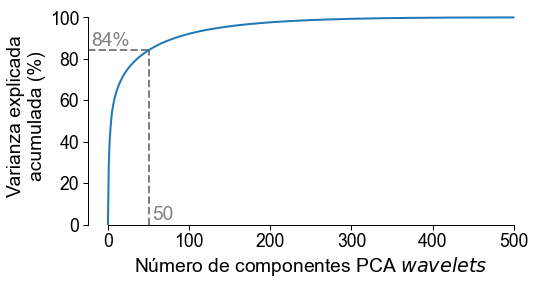

In [192]:
plt.figure(figsize=(8, 4))
variance = np.concatenate(([0], np.cumsum(wav_pca.explained_variance_ratio_) * 100))
plt.plot(variance, lw=2)
plt.xlabel(r"Número de componentes PCA $wavelets$")
plt.ylabel("Varianza explicada\nacumulada (%)")
xlim = plt.gca().get_xlim()
ylim = 0, 105
plt.hlines(y=variance[50], xmin=xlim[0], xmax=50, color="0.5", ls="--", lw=2)
plt.vlines(x=50, ymin=ylim[0], ymax=variance[50], color="0.5", ls="--", lw=2)
plt.text(x=55, y=2, s="50", color="0.5")
plt.text(x=-20, y=variance[50] + 2, s=f"{variance[50]:.0f}%", color="0.5")
plt.xlim(*xlim)
plt.ylim(*ylim)
sns.despine(trim=True)
plt.gca().tick_params(bottom=True, left=True)
plt.savefig(config_dodo.FIG_PATH / "Wavelets" / "varianza_pca.pdf", bbox_inches="tight", dpi=600)
plt.savefig(config_dodo.FIG_PATH / "Wavelets" / "varianza_pca.png", bbox_inches="tight", dpi=600)
plt.show()
plt.close()


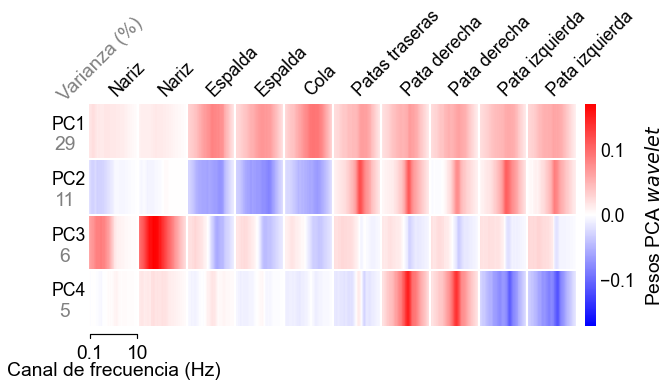

Varianza explicada por cada componente:
PC1: 0.29 PC2: 0.11 PC3: 0.06 PC4: 0.05
Varianza total explicada por estas componentes:
0.51


In [11]:
left, width_im = 0.0, 0.65
bottom, height_im = 0.0, 0.65
width_annot, height_annot = 0.52, 0.1
spacing = 0.005

rect_im = [left, bottom + height_annot + spacing, width_im, height_im]
rect_annot = [left, bottom, width_annot, height_annot]

fig = plt.figure(figsize=(13, 4.75))
ax_im = fig.add_axes(rect_im, frameon=False)
ax_annot = fig.add_axes(rect_annot, frameon=False)

n_components = 4
vext = np.abs(wav_pca.components_[:n_components]).max()
wav_pca_reorder = np.copy(wav_pca.components_[:n_components])
reidx = np.concatenate([np.arange(i * 50, (i + 1) * 50) for i in np.arange(10)[::-1]])
sns.heatmap(wav_pca.components_[:n_components][:, reidx], cmap="bwr", vmin=-vext, vmax=vext, ax=ax_im)
cax = ax_im.collections[0].colorbar
cax.set_label(label=r"Pesos PCA $wavelet$", labelpad=10)
cax.ax.tick_params(axis="both", which="both", length=0)
cax.ax.set_position([0.53, 0.105, 0.02, 0.65])
ax_im.vlines(config.WAV_NUM_CHANNELS * np.arange(1, 10), *ax_im.get_ylim(), colors="1", lw=2)
ax_im.hlines(np.arange(1, n_components), *ax_im.get_xlim(), colors="1", lw=2)
ax_im.set_yticklabels([f"PC{i}\n " for i in np.arange(1, n_components + 1)], rotation=0)
ax_im.text(-35, -0.8, "Varianza (%)", color="0.5", ha="left", va="center", rotation=45)
for i in np.arange(1, n_components + 1):
    ax_im.text(-25, i - 0.25, f"{(wav_pca.explained_variance_ratio_[i - 1] * 100):.0f}", color="0.5", ha="center", va="center")
ax_im.set_xticks(np.arange(18, 500, 50))
ang_nombres = [
    "Nariz",
    "Nariz",
    "Espalda",
    "Espalda",
    "Cola",
    "Patas traseras",
    "Pata derecha",
    "Pata derecha",
    "Pata izquierda",
    "Pata izquierda",
]
ax_im.set_xticklabels(ang_nombres, rotation=45, ha="left")
ax_im.xaxis.set_ticks_position("top")
ax_im.tick_params(axis="both", which="both", length=0)
pos_frec = 0.5
ax_annot.plot([pos_frec, pos_frec, pos_frec + 49, pos_frec + 49], [-0.15, -0.1, -0.1, -0.15], "k")
ax_annot.text(pos_frec, -0.25, "0.1", va="top", ha="center")
ax_annot.text(pos_frec + 49, -0.25, "10", va="top", ha="center")
ax_annot.text(pos_frec + 25, -0.5, "Canal de frecuencia (Hz)", va="top", ha="center")
ax_annot.set_ylim(-0.5, 0)
ax_annot.set_xlim(*ax_im.get_xlim())
ax_annot.set_xticks([])
ax_annot.set_yticks([])
plt.savefig(config_dodo.FIG_PATH / "Wavelets" / "pesos_pca.pdf", bbox_inches="tight", dpi=600)
plt.savefig(config_dodo.FIG_PATH / "Wavelets" / "pesos_pca.png", bbox_inches="tight", dpi=600)
plt.show()
plt.close()

print("Varianza explicada por cada componente:")
print(*[f"PC{i+1}: {v:.2f}" for i, v in enumerate(wav_pca.explained_variance_ratio_[:n_components])])

print("Varianza total explicada por estas componentes:")
print(f"{wav_pca.explained_variance_ratio_[:n_components].sum():.2f}")

In [6]:
config.WAV_F_CHANNELS

array([ 0.1       ,  0.10985411,  0.12067926,  0.13257114,  0.14563485,
        0.15998587,  0.17575106,  0.19306977,  0.21209509,  0.23299518,
        0.25595479,  0.28117687,  0.30888436,  0.33932218,  0.37275937,
        0.40949151,  0.44984327,  0.49417134,  0.54286754,  0.59636233,
        0.65512856,  0.71968567,  0.79060432,  0.86851137,  0.95409548,
        1.04811313,  1.1513954 ,  1.26485522,  1.38949549,  1.52641797,
        1.67683294,  1.84206997,  2.02358965,  2.22299648,  2.44205309,
        2.6826958 ,  2.9470517 ,  3.23745754,  3.55648031,  3.90693994,
        4.29193426,  4.71486636,  5.17947468,  5.68986603,  6.25055193,
        6.86648845,  7.54312006,  8.28642773,  9.10298178, 10.        ])

In [7]:
def _prepare_data_corr_plot(x, lags, zero=True):
    zero = bool(zero)
    irregular = False if zero else True
    if lags is None:
        nobs = x.shape[0]
        lim = min(int(np.ceil(10 * np.log10(nobs))), nobs - 1)
        lags = np.arange(not zero, lim + 1)
    elif np.isscalar(lags):
        lags = np.arange(not zero, int(lags) + 1)
    else:
        irregular = True
        lags = np.asanyarray(lags).astype(int)
    nlags = lags.max(0)
    return lags, nlags, irregular

def get_tau(x, lags, alpha):
    lags, nlags, irregular = _prepare_data_corr_plot(x=x, lags=lags)
    acf_x, confint = sm.tsa.stattools.acf(x, nlags=nlags, alpha=alpha)
    if irregular:
        acf_x = acf_x[lags]
        if confint is not None:
            confint = confint[lags]
    if confint is not None:
        if lags[0] == 0:
            lags = lags[1:]
            confint = confint[1:]
            acf_x = acf_x[1:]
        lags = lags.astype(float)
        lags[0] -= 0.5
        lags[-1] += 0.5
    tau = np.where(confint[:, 0] < 0)[0][0]
    return tau
    
colors = cm.tab10(np.linspace(0, 1, 10))
ss = wav_pca.transform(wav)[:, :config.PCA_WAV_NUM_COMPONENTS]
taus = []
lags = 10000
alpha = 0.001
for i in range(ss.shape[1]):
    taus.append(get_tau(ss[:, i], lags, alpha))

/home/alvaro/.local/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


/tmp/ipykernel_4492/38902245.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(np.vectorize(lambda x: f"{x:.0f}")(plt.gca().get_xticks() * 0.01))


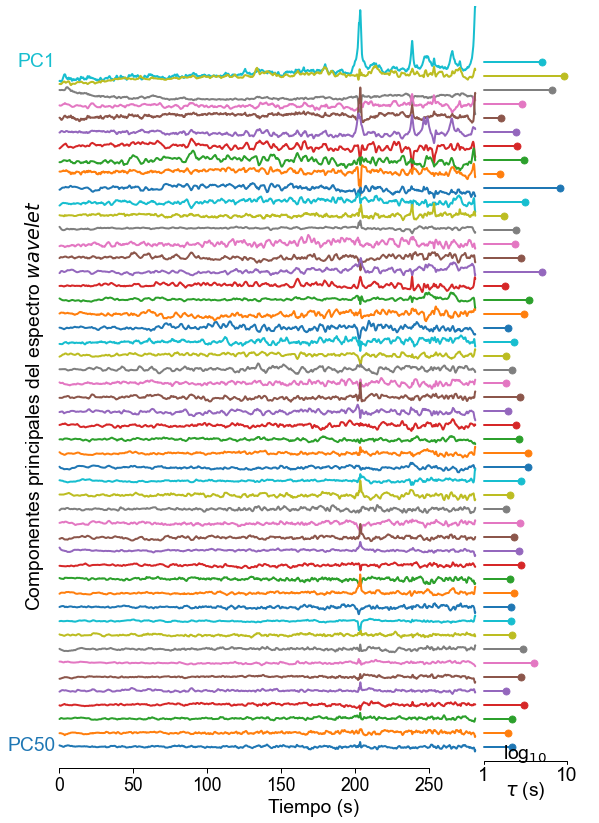

In [15]:
plt.figure(figsize=(10, 14))
ss = wav_pca.transform(wav)[:, :config.PCA_WAV_NUM_COMPONENTS]
# dy = 0.75
dy = 0.3
for i in range(ss.shape[1]):
    plt.plot(ss[:, i] + (ss.shape[1] - i) * dy, lw=2, c=colors[9 - i%10])
    if i in [0, ss.shape[1] - 1]:
        plt.text(-len(ss) * 0.01, (ss.shape[1] - i - 0.25) * dy, f"PC{i + 1}", color=colors[9 - i%10], ha="right")
dx = len(ss) * 0.05
plt.text(-1.2 * dx, (ss.shape[1] * 0.5 + 0.5) * dy, r"Componentes principales del espectro $wavelet$", rotation=90, va="center", ha="center")
plt.gca().set_xticklabels(np.vectorize(lambda x: f"{x:.0f}")(plt.gca().get_xticks() * 0.01))
plt.xlabel("Tiempo (s)")
sns.despine(trim=True)
t0 = len(ss) * 1.02
tscale = len(ss) * 0.2
tmax = 1000
tmin = 100
for i in range(ss.shape[1]):
    plt.plot(
        [t0, t0 + (np.log10(taus[i]) - np.log10(tmin)) / (np.log10(tmax) - np.log10(tmin)) * tscale], [(ss.shape[1] - i) * dy] * 2,
        lw=2, c=colors[9 - i%10]
    )
    plt.scatter(
        t0 + (np.log10(taus[i]) - np.log10(tmin)) / (np.log10(tmax) - np.log10(tmin)) * tscale, (ss.shape[1] - i) * dy,
        color=colors[9 - i%10], s=50
    )
plt.plot(
    [t0, t0, t0 + tscale, t0 + tscale], [-0.25 * dy, -0.05 * dy, -0.05 * dy, -0.25 * dy],
    lw=1, c="k"
)
plt.text(t0 + tscale * 0.5, 0.5 * dy, r"log$_{10}$", va="center", ha="center")
plt.text(t0, -0.4 * dy, "1", va="top", ha="center")
plt.text(t0 + tscale, -0.4 * dy, "10", va="top", ha="center")
plt.text(t0 + tscale * 0.5, -2.1 * dy, r"$\tau$ (s)", va="center", ha="center")
plt.gca().tick_params(bottom=True, left=False, labelbottom=True, labelleft=False)
plt.gca().spines["left"].set_visible(False)
plt.gca().set_xticklabels(np.vectorize(lambda x: f"{x:.0f}")(plt.gca().get_xticks() * 0.01))
plt.ylim(-0.5 * dy, (ss.shape[1] + 4) * dy)
plt.savefig(config_dodo.FIG_PATH / "Wavelets" / "componentes_pca.pdf", bbox_inches="tight", dpi=600)
plt.savefig(config_dodo.FIG_PATH / "Wavelets" / "componentes_pca.png", bbox_inches="tight", dpi=600)
plt.show()
plt.close()

In [49]:
print(np.min(taus), np.max(taus))

156 933


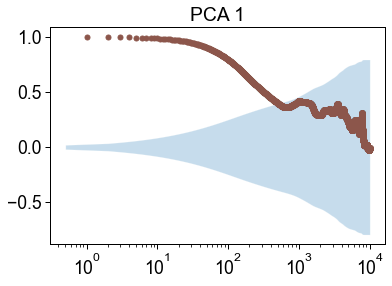

In [76]:
ss = wav_pca.transform(wav)[:, :config.PCA_WAV_NUM_COMPONENTS]
# for i in range(ss.shape[1]):
for i in [0]:
    sm.graphics.tsa.plot_acf(
        ss[:, i], lags=10000, use_vlines=False, c=colors[5 - i%6], title=f"PCA {i + 1}",
        alpha=0.001,
    )
    plt.xscale("log")
    plt.show()
    plt.close()

/tmp/ipykernel_4437/4261713875.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[-1].set_xticklabels(np.vectorize(lambda x: f"{x:.0f}")(axs[-1].get_xticks() * 0.01))


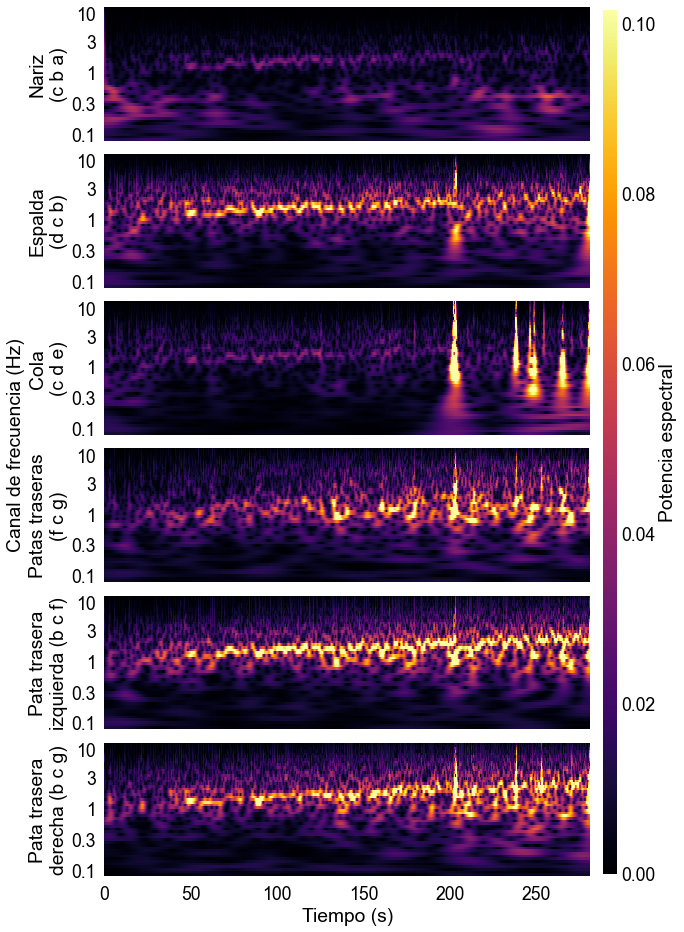

In [34]:
cmap = "inferno"
ANG_MARKER_IDX = [
    [4, 17, 0],  # left hindpaw
    [17, 0, 4],  # left hindpaw
    [4, 17, 1],  # right hindpaw
    [17, 1, 4],  # right hindpaw
    [0, 17, 1],  # cm hindpaws
    [17, 2, 3],  # tail
    [2, 17, 4],  # back
    [17, 4, 2],  # back
    [4, 16, 17],  # nose
    [17, 4, 16],  # nose
]
idxs = [9, 7, 5, 4, 0, 2]
noms = ["Nariz\n(c b a)", "Espalda\n(d c b)", "Cola\n(c d e)", "Patas traseras\n(f c g)", "Pata trasera\nizquierda (b c f)", "Pata trasera\nderecha (b c g)"]
vmin = 0
vmax = np.quantile(wav, 0.99)
fig, axs = plt.subplots(len(idxs), 1, figsize=(10, 16), sharex=True)
for i, ax in enumerate(axs):
    im = ax.imshow(
        wav[:, idxs[i] * config.WAV_NUM_CHANNELS: (idxs[i] + 1) * config.WAV_NUM_CHANNELS].T,
        aspect="auto", origin="lower", cmap=cmap, interpolation="none", vmin=vmin, vmax=vmax,
    )
    ax.set_ylabel(noms[i])
    # ax.set_yticks([0, 12.5, 25, 37.5, 49])
    ax.set_yticks([2, 13.5, 25, 36.5, 47])
    ax.set_yticklabels(["0.1", "0.3", "1", "3", "10"])
    ax.tick_params(bottom=False, left=False)
    ax.set_frame_on(False)
axs[-1].set_xticklabels(np.vectorize(lambda x: f"{x:.0f}")(axs[-1].get_xticks() * 0.01))
plt.xlabel("Tiempo (s)")
fig.subplots_adjust(right=0.8)
cax = fig.add_axes([0.8175, 0.1275, 0.02, 0.75])
cbar = fig.colorbar(im, cax=cax)
cbar.set_label("Potencia espectral")
cbar.ax.set_frame_on(False)
cbar.ax.tick_params(axis="both", which="both", length=0)
plt.figtext(-0.01, 0.5, "Canal de frecuencia (Hz)", rotation=90, va="center")
fig.subplots_adjust(hspace=0.1, wspace=0.05)
plt.savefig(config_dodo.FIG_PATH / "Wavelets" / "espectros_wavelet.pdf", bbox_inches="tight", dpi=600)
plt.savefig(config_dodo.FIG_PATH / "Wavelets" / "espectros_wavelet.png", bbox_inches="tight", dpi=600)
plt.show()
plt.close()

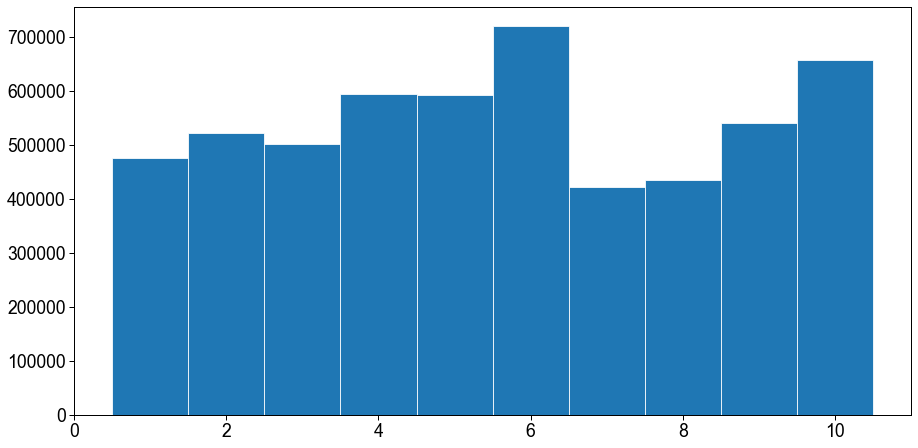

In [9]:
plt.figure(figsize=(15, 7.5))
plt.hist(label_wav_all, bins=np.arange(0.5, 11.5)) # labels
plt.show()
plt.close()

In [11]:
def get_step_indices(latency_offset, events, hindpaw):
    """Returns step global indices."""
    indices = events.query("hindpaw == @hindpaw")["t_dy_max"].to_numpy()
    return indices + latency_offset
left_steps = []
right_steps = []
latency_sum = 0
for key in config_dodo.KEY_LIST:
    name = config_dodo.SUBJECT_NAME.format(*key)
    pickle_end = name + ".pickle"
    latency = read_pickle(config_dodo.MTR_PATH / f"Latency/latency_{pickle_end}")
    events = read_pickle(config_dodo.MTR_PATH / f"Step/step_events_{pickle_end}")
    left_steps.append(get_step_indices(latency_offset=latency_sum, events=events, hindpaw="left"))
    right_steps.append(get_step_indices(latency_offset=latency_sum, events=events, hindpaw="right"))
    latency_sum += latency
left_steps = np.concatenate(left_steps)
right_steps = np.concatenate(right_steps)

In [12]:
left_kde_wavs = read_pickle(config_dodo.FIG_PATH / "Embeddings/Colors/Wavelets" / "left_kde_wavs.pickle")
right_kde_wavs = read_pickle(config_dodo.FIG_PATH / "Embeddings/Colors/Wavelets" / "right_kde_wavs.pickle")
hp_kde_wavs = read_pickle(config_dodo.FIG_PATH / "Embeddings/Colors/Wavelets" / "hp_kde_wavs.pickle")
lp_kde_wavs = read_pickle(config_dodo.FIG_PATH / "Embeddings/Colors/Wavelets" / "lp_kde_wavs.pickle")
days_kde_wavs = read_pickle(config_dodo.FIG_PATH / "Embeddings/Colors/Wavelets" / "days_kde_wavs.pickle")

In [13]:
def get_wavelets_gaussian_convolution(img, emb_sigma):
    """Convolve wavelet outcomes density with gaussian kernel."""
    sigma = (
        emb_sigma
        * config.WAT_RESOLUTION
        / (config.WAT_EMB_WAV_MAIN[1] - config.WAT_EMB_WAV_MAIN[0])
    )
    img_smooth = gaussian(img, sigma=sigma)
    img_smooth /= np.sum(img_smooth)
    return img_smooth

emb_sigma = 0.5
right_pdf_wavs = get_wavelets_gaussian_convolution(right_kde_wavs, emb_sigma)
left_pdf_wavs = get_wavelets_gaussian_convolution(left_kde_wavs, emb_sigma)

max_pdf_wavs = np.maximum(right_pdf_wavs.max(), left_pdf_wavs.max())
right_pdf_wavs /= max_pdf_wavs
left_pdf_wavs /= max_pdf_wavs

hp_pdf_wavs = get_wavelets_gaussian_convolution(hp_kde_wavs, emb_sigma)
lp_pdf_wavs = get_wavelets_gaussian_convolution(lp_kde_wavs, emb_sigma)

max_pdf_wavs = np.maximum(hp_pdf_wavs.max(), lp_pdf_wavs.max())
hp_pdf_wavs /= max_pdf_wavs
lp_pdf_wavs /= max_pdf_wavs

days_pdf_wavs = []
for i in range(len(days_kde_wavs)):
    day_pdf_wavs = get_wavelets_gaussian_convolution(days_kde_wavs[i], emb_sigma)
    days_pdf_wavs.append(day_pdf_wavs)
max_pdf_wavs = np.max(days_pdf_wavs)
for i in range(len(days_kde_wavs)):
    days_pdf_wavs[i] /= max_pdf_wavs

In [30]:
# emb_sigma = 0.5
# axes_wavs = [
#     np.linspace(*config.WAT_EMB_WAV_MAIN, config.WAT_RESOLUTION + 1)
#     for _ in range(2)
# ]
# right_out_wavs = out_wav_all[right_steps]
# left_out_wavs = out_wav_all[left_steps]
# right_kde_wavs, _ = fastKDE.pdf(
#     right_out_wavs[:, 0],
#     right_out_wavs[:, 1],
#     axes=axes_wavs,
# )
# left_kde_wavs, _ = fastKDE.pdf(
#     left_out_wavs[:, 0],
#     left_out_wavs[:, 1],
#     axes=axes_wavs,
# )
# right_pdf_wavs = get_wavelets_gaussian_convolution(right_kde_wavs, emb_sigma)
# left_pdf_wavs = get_wavelets_gaussian_convolution(left_kde_wavs, emb_sigma)

# max_pdf_wavs = np.maximum(right_pdf_wavs.max(), left_pdf_wavs.max())
# right_pdf_wavs /= max_pdf_wavs
# left_pdf_wavs /= max_pdf_wavs

# hp_sample_idx_wav = long_data.iloc[sample_idx_wav].query("mouse in @config_dodo.HP_MOUSE_LIST").index
# lp_sample_idx_wav = long_data.iloc[sample_idx_wav].query("mouse in @config_dodo.LP_MOUSE_LIST").index
# hp_out_wavs = out_wav_all[hp_sample_idx_wav]
# lp_out_wavs = out_wav_all[lp_sample_idx_wav]
# hp_kde_wavs, _ = fastKDE.pdf(
#     hp_out_wavs[:, 0],
#     hp_out_wavs[:, 1],
#     axes=axes_wavs,
# )
# lp_kde_wavs, _ = fastKDE.pdf(
#     lp_out_wavs[:, 0],
#     lp_out_wavs[:, 1],
#     axes=axes_wavs,
# )

# hp_pdf_wavs = get_wavelets_gaussian_convolution(hp_kde_wavs, emb_sigma)
# lp_pdf_wavs = get_wavelets_gaussian_convolution(lp_kde_wavs, emb_sigma)

# max_pdf_wavs = np.maximum(hp_pdf_wavs.max(), lp_pdf_wavs.max())
# hp_pdf_wavs /= max_pdf_wavs
# lp_pdf_wavs /= max_pdf_wavs

# days_kde_wavs = []
# for d in config_dodo.DAY_LIST:
#     day_sample_idx_wav = long_data.iloc[sample_idx_wav].query("day == @d").index
#     day_out_wavs = out_wav_all[day_sample_idx_wav]
#     day_kde_wavs, _ = fastKDE.pdf(
#         day_out_wavs[:, 0],
#         day_out_wavs[:, 1],
#         axes=axes_wavs,
#     )
#     days_kde_wavs.append(day_kde_wavs)

# days_pdf_wavs = []
# for i in range(len(days_kde_wavs)):
#     day_pdf_wavs = get_wavelets_gaussian_convolution(days_kde_wavs[i], emb_sigma)
#     days_pdf_wavs.append(day_pdf_wavs)
# max_pdf_wavs = np.max(days_pdf_wavs)
# for i in range(len(days_kde_wavs)):
#     days_pdf_wavs[i] /= max_pdf_wavs

/usr/local/lib/python3.8/dist-packages/seaborn/utils.py:317: UserWarning: Use the colorbar set_ticks() method instead.
  ax_i.set_yticks(newticks)


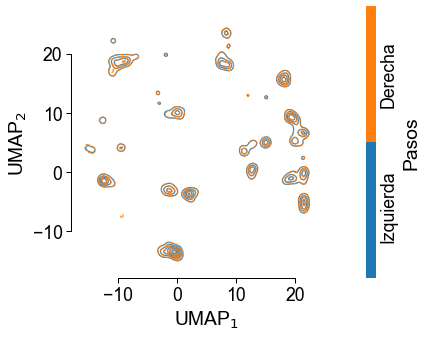

In [31]:
# save_name = "pasos_wav.png"
save_name = "pasos_wav.pdf"
label = "Pasos"
plt.figure(figsize=(6, 5))
plt.contour(left_pdf_wavs, alpha=0.9, colors="tab:blue", extent=config.WAT_EMB_WAV_MAIN + config.WAT_EMB_WAV_MAIN)
plt.contour(right_pdf_wavs, alpha=0.9, colors="tab:orange", linestyles="dashed", extent=config.WAT_EMB_WAV_MAIN + config.WAT_EMB_WAV_MAIN)
norm = Normalize(vmin=0.5, vmax=10.5)
mappable = ScalarMappable(norm=norm, cmap="tab10")
mappable.set_array(range(1, 3))
cbar = plt.colorbar(mappable, ax=plt.gca(), pad=0.0)
cbar.set_label(label=label, labelpad=5)
cbar.ax.set_xlim(-2, 2)
cbar.ax.set_ylim(0.5, 2.5)
cbar.set_ticks([1.25, 2.2])
cbar.set_ticklabels(["Izquierda", "Derecha"])
cbar.ax.set_frame_on(False)
cbar.ax.tick_params(axis="both", which="both", length=0, rotation=90)
plt.xlabel(r"UMAP$_1$")
plt.ylabel(r"UMAP$_2$")
sns.despine(trim=True)
plt.gca().tick_params(bottom=True, left=True)
plt.axis("scaled")
plt.savefig(config_dodo.FIG_PATH / "Embeddings/Colors/Wavelets" / save_name, bbox_inches="tight", dpi=600)
plt.show()
plt.close()

/usr/local/lib/python3.8/dist-packages/seaborn/utils.py:317: UserWarning: Use the colorbar set_ticks() method instead.
  ax_i.set_yticks(newticks)


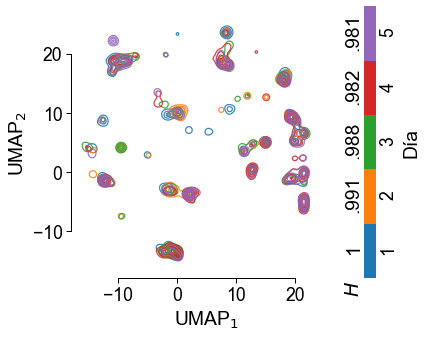

In [33]:
# save_name = "dias_wav.png"
save_name = "dias_wav.pdf"
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]
label = "Día"
plt.figure(figsize=(6, 5))
for i in range(len(days_pdf_wavs)):
    cs = plt.contour(days_pdf_wavs[i], alpha=0.9, colors=colors[i], extent=config.WAT_EMB_WAV_MAIN + config.WAT_EMB_WAV_MAIN)
    cs.collections[0].remove() # Eliminar el contorno de menor nivel feo
norm = Normalize(vmin=0.5, vmax=10.5)
mappable = ScalarMappable(norm=norm, cmap="tab10")
mappable.set_array(range(1, 6))
cbar = plt.colorbar(mappable, ax=plt.gca(), pad=0.0)
cbar.set_label(label=label, labelpad=5)
cbar.ax.set_xlim(-5, 5)
cbar.ax.set_ylim(0.5, 5.5)
cbar.set_ticks(range(1, 6))
cbar.set_ticklabels(range(1, 6))
cbar.ax.set_frame_on(False)
cbar.ax.tick_params(axis="both", which="both", length=0, rotation=90)
plt.xlabel(r"UMAP$_1$")
plt.ylabel(r"UMAP$_2$")
sns.despine(trim=True)
plt.gca().tick_params(bottom=True, left=True)
plt.axis("scaled")
ref_entropy = entropy(days_pdf_wavs[0].flatten())
x_text = 0.795
y_text_ini = 0.21
y_text_delta = 0.15
plt.figtext(x_text, y_text_ini - y_text_delta * 0.75, r"$H$", ha="center", va="center", rotation=90)
for i in range(5):
    rel_entropy = entropy(days_pdf_wavs[i].flatten()) / ref_entropy
    if i == 0:
        plt.figtext(x_text, y_text_ini + i * y_text_delta, "1", ha="center", va="center", rotation=90)
    else:
        plt.figtext(x_text, y_text_ini + i * y_text_delta, f"{rel_entropy:.3f}"[1:], ha="center", va="center", rotation=90)
plt.savefig(config_dodo.FIG_PATH / "Embeddings/Colors/Wavelets" / save_name, bbox_inches="tight", dpi=600)
plt.show()
plt.close()

/usr/local/lib/python3.8/dist-packages/seaborn/utils.py:317: UserWarning: Use the colorbar set_ticks() method instead.
  ax_i.set_yticks(newticks)


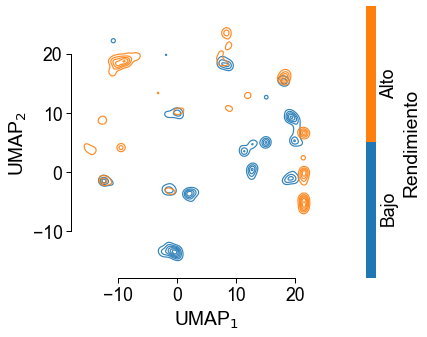

In [34]:
# save_name = "rendimiento_wav.png"
save_name = "rendimiento_wav.pdf"
label = "Rendimiento"
plt.figure(figsize=(6, 5))
lp_cs = plt.contour(lp_pdf_wavs, alpha=0.9, colors="tab:blue", extent=config.WAT_EMB_WAV_MAIN + config.WAT_EMB_WAV_MAIN)
# lp_cs.collections[0].remove() # Eliminar el contorno de menor nivel feo
hp_cs = plt.contour(hp_pdf_wavs, alpha=0.9, colors="tab:orange", extent=config.WAT_EMB_WAV_MAIN + config.WAT_EMB_WAV_MAIN)
# hp_cs.collections[0].remove() # Eliminar el contorno de menor nivel feo
norm = Normalize(vmin=0.5, vmax=10.5)
mappable = ScalarMappable(norm=norm, cmap="tab10")
mappable.set_array(range(1, 3))
cbar = plt.colorbar(mappable, ax=plt.gca(), pad=0.0)
cbar.set_label(label=label, labelpad=5)
cbar.ax.set_xlim(-2, 2)
cbar.ax.set_ylim(0.5, 2.5)
cbar.set_ticks([1.1, 2])
cbar.set_ticklabels(["Bajo", "Alto"])
cbar.ax.set_frame_on(False)
cbar.ax.tick_params(axis="both", which="both", length=0, rotation=90)
plt.xlabel(r"UMAP$_1$")
plt.ylabel(r"UMAP$_2$")
sns.despine(trim=True)
plt.gca().tick_params(bottom=True, left=True)
plt.axis("scaled")
plt.savefig(config_dodo.FIG_PATH / "Embeddings/Colors/Wavelets" / save_name, bbox_inches="tight", dpi=600)
plt.show()
plt.close()

In [32]:
# write_pickle(left_kde_wavs, config_dodo.FIG_PATH / "Embeddings/Colors/Wavelets" / "left_kde_wavs.pickle")
# write_pickle(right_kde_wavs, config_dodo.FIG_PATH / "Embeddings/Colors/Wavelets" / "right_kde_wavs.pickle")
# write_pickle(hp_kde_wavs, config_dodo.FIG_PATH / "Embeddings/Colors/Wavelets" / "hp_kde_wavs.pickle")
# write_pickle(lp_kde_wavs, config_dodo.FIG_PATH / "Embeddings/Colors/Wavelets" / "lp_kde_wavs.pickle")
# write_pickle(days_kde_wavs, config_dodo.FIG_PATH / "Embeddings/Colors/Wavelets" / "days_kde_wavs.pickle")

In [ ]:
# long_data_group = long_data.groupby(["sequence_group_wav"])
# seq_data_wav = pd.concat(
#     [
#         long_data_group[["mouse", "day", "trial", "label_wav", "sequence_group_wav"]]
#         .median()
#         .applymap(int),
#         long_data_group["sequence_group_wav"].count().rename("duration"),
#         long_data_group["sequence_group_wav"]
#         .count()
#         .apply(np.log10)
#         .rename("log_duration"),
#         long_data_group[["local_idx", "global_idx"]].first(),
#     ],
#     axis=1,
# ).reset_index(drop=True)
# write_pickle(seq_data_wav, config_dodo.LAB_PATH / "label_sequence_data_wav.pickle")

/usr/local/lib/python3.8/dist-packages/seaborn/utils.py:317: UserWarning: Use the colorbar set_ticks() method instead.
  ax_i.set_yticks(newticks)


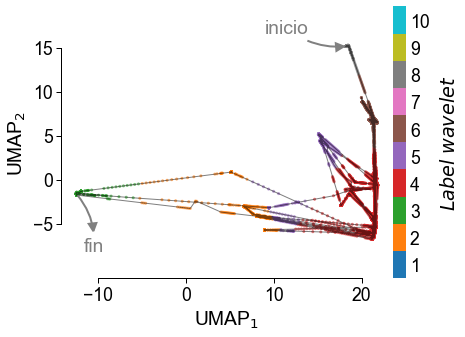

In [12]:
# see = long_data.query("mouse == 262 and day == 1 and trial == 1")
# see = long_data.query("mouse == 262 and day == 5 and trial == 1")
# see = long_data.query("mouse == 264 and day == 1 and trial == 1")
# see = long_data.query("mouse == 264 and day == 5 and trial == 1")
# see = long_data.query("mouse == 282 and day == 1 and trial == 1")
# see = long_data.query("mouse == 282 and day == 5 and trial == 1")
# see = long_data.query("mouse == 297 and day == 1 and trial == 1")
# see = long_data.query("mouse == 297 and day == 5 and trial == 1")
see = long_data.query("mouse == 297 and day == 5 and trial == 2")
# see = long_data.query("mouse == 297 and day == 5 and trial == 3")
# see = long_data.query("mouse == 329 and day == 1 and trial == 1")
# see = long_data.query("mouse == 329 and day == 5 and trial == 1")
color = label_wav_all[see.index]
label = r"$Label$ $wavelet$"
save_name = "label_serie_mapa_wav"
color_dict = dict(zip(range(1, 11), plt.cm.tab10.colors))
color = np.array(np.vectorize(color_dict.get)(color)).T
plt.figure(figsize=(7, 5))
plt.scatter(*out_wav_all[see.index].T, c=color, s=5, alpha=0.5)
plt.plot(*out_wav_all[see.index].T, c="k", alpha=0.5, lw=1)
xy = out_wav_all[see.index[0]]
plt.annotate(
    "inicio", xy=xy, xytext=xy + (-7, 2), ha="center", va="center", color="0.5",
    arrowprops=dict(arrowstyle="-|>", connectionstyle="arc3,rad=0.2", color="0.5", lw=2, joinstyle="miter", capstyle="butt")
)
xy = out_wav_all[see.index[-1]]
plt.annotate(
    "fin", xy=xy, xytext=xy + (2, -5), ha="center", va="top", color="0.5",
    arrowprops=dict(arrowstyle="<|-", connectionstyle="arc3,rad=0.2", color="0.5", lw=2, joinstyle="miter", capstyle="butt")
)
norm = Normalize(vmin=0.5, vmax=10.5)
mappable = ScalarMappable(norm=norm, cmap="tab10")
mappable.set_array(color)
cbar = plt.colorbar(mappable, ax=plt.gca(), pad=0.0)
cbar.set_label(label=label, labelpad=10)
cbar.set_ticks(range(1, 11))
cbar.set_ticklabels(range(1, 11))
cbar.ax.set_frame_on(False)
cbar.ax.tick_params(axis="both", which="both", length=0)
plt.xlabel(r"UMAP$_1$")
plt.ylabel(r"UMAP$_2$")
plt.xlim(config.WAT_EMB_WAV_MAIN)
plt.ylim(config.WAT_EMB_WAV_MAIN)
plt.axis("equal")
sns.despine(trim=True)
plt.gca().tick_params(bottom=True, left=True)
plt.savefig(config_dodo.FIG_PATH / "Transitions" / (save_name + ".pdf"), bbox_inches="tight", dpi=600)
plt.savefig(config_dodo.FIG_PATH / "Transitions" / (save_name + ".png"), bbox_inches="tight", dpi=150)
plt.show()
plt.close()

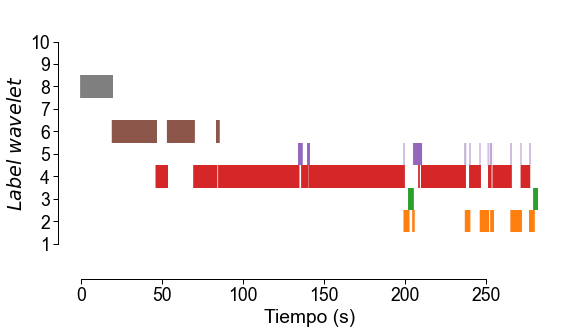

In [11]:
see = long_data.query("mouse == 297 and day == 5 and trial == 2")
ls = label_wav_all[see.index]
save_name = "label_secuencia_wav"
evs = [np.where(ls==l)[0] for l in range(1, 11)]
plt.figure(figsize=(9, 5))
plt.eventplot(evs, colors=cm.tab10(np.linspace(0, 1, 10)), lw=0.1)
plt.gca().set_yticks(range(10))
plt.gca().set_yticklabels(range(1, 11))
plt.ylabel(r"$Label$ $wavelet$")
plt.xlabel("Tiempo (s)")
sns.despine(trim=True)
plt.gca().tick_params(bottom=True, left=True)
plt.gca().set_xticklabels(np.vectorize(lambda x: f"{x:.0f}")(plt.gca().get_xticks() * 0.01))
plt.savefig(config_dodo.FIG_PATH / "Transitions" / (save_name + ".pdf"), bbox_inches="tight", dpi=600)
plt.savefig(config_dodo.FIG_PATH / "Transitions" / (save_name + ".png"), bbox_inches="tight", dpi=150)
plt.show()
plt.close()

/usr/local/lib/python3.8/dist-packages/seaborn/utils.py:317: UserWarning: Use the colorbar set_ticks() method instead.
  ax_i.set_yticks(newticks)


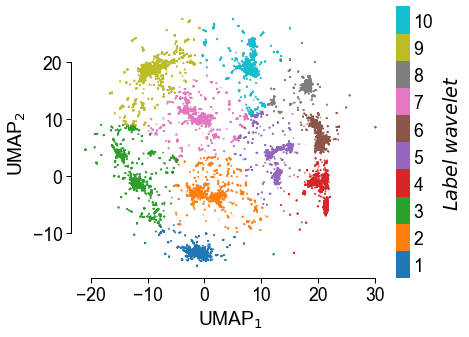

In [7]:
color = label_wav_all[sample_idx_wav]
label = r"$Label$ $wavelet$"
save_name = "label_wav.png"
# color = label_stp_all[sample_idx_wav]
# label = r"$Label$ pasos y poses"
# save_name = "label_contra_wav.png"
# color = next_group_wav_label
# label = r"$Label$ siguiente en la secuencia"
# save_name = "siguiente_label_wav.png"
# color = previous_group_wav_label
# label = r"$Label$ anterior en la secuencia"
# save_name = "label_anterior_wav.png"
plt.figure(figsize=(7, 5))
plt.scatter(*out_wav.T, c=color, cmap="tab10", s=1, alpha=0.1)
norm = Normalize(vmin=0.5, vmax=10.5)
mappable = ScalarMappable(norm=norm, cmap="tab10")
mappable.set_array(color)
cbar = plt.colorbar(mappable, ax=plt.gca(), pad=0.0)
cbar.set_label(label=label, labelpad=10)
cbar.set_ticks(range(1, 11))
cbar.set_ticklabels(range(1, 11))
cbar.ax.set_frame_on(False)
cbar.ax.tick_params(axis="both", which="both", length=0)
plt.xlabel(r"UMAP$_1$")
plt.ylabel(r"UMAP$_2$")
sns.despine(trim=True)
plt.gca().tick_params(bottom=True, left=True)
plt.axis("scaled")
# plt.savefig(config_dodo.FIG_PATH / "Embeddings/Colors/Wavelets" / save_name, bbox_inches="tight", dpi=600)
plt.show()
plt.close()

/usr/local/lib/python3.8/dist-packages/seaborn/utils.py:317: UserWarning: Use the colorbar set_ticks() method instead.
  ax_i.set_yticks(newticks)


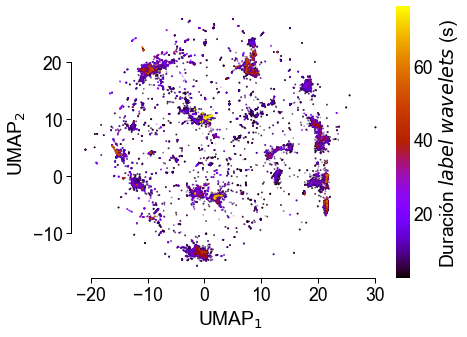

In [33]:
color = duration_wav
label = r"Duración $label$ $wavelets$ (s)"
save_name = "label_duracion_wav.png"
cmap = "gnuplot"
plt.figure(figsize=(7, 5))
sort_idx = np.argsort(color)
plt.scatter(*out_wav[sort_idx].T, c=color[sort_idx], cmap=cmap, s=1, alpha=0.05)
vmin = np.quantile(color, 0.05)
vmax = np.quantile(color, 0.95)
norm = Normalize(vmin=vmin, vmax=vmax)
mappable = ScalarMappable(norm=norm, cmap=cmap)
mappable.set_array(color)
cbar = plt.colorbar(mappable, ax=plt.gca(), pad=0.0)
cbar.set_label(label=label)
cbar.ax.set_frame_on(False)
cbar.ax.tick_params(axis="both", which="both", length=0)
plt.xlabel(r"UMAP$_1$")
plt.ylabel(r"UMAP$_2$")
sns.despine(trim=True)
plt.gca().tick_params(bottom=True, left=True)
plt.axis("scaled")
plt.savefig(config_dodo.FIG_PATH / "Embeddings/Colors/Wavelets" / save_name, bbox_inches="tight", dpi=600)
plt.show()
plt.close()

In [206]:
color_list = [
    long_data.iloc[sample_idx_wav]["local_idx"].to_numpy() / config.WAV_F_SAMPLING,
    wav_sample[:, 112], # canal 12 del angulo de pata der
    wav_sample[:, 125], # canal 25 del angulo de pata der
    wav_sample[:, 136], # canal 36 del angulo de pata der
    wav_sample[:, 212], # canal 12 del angulo de patas traseras
    wav_sample[:, 225], # canal 25 del angulo de patas traseras
    wav_sample[:, 236], # canal 36 del angulo de patas traseras
    wav_sample[:, 262], # canal 12 del angulo de cola
    wav_sample[:, 275], # canal 25 del angulo de cola
    wav_sample[:, 286], # canal 36 del angulo de cola
    wav_sample[:, 452], # canal 12 del angulo de nariz
    wav_sample[:, 475], # canal 25 del angulo de nariz
    wav_sample[:, 486], # canal 36 del angulo de nariz
    pca_wav_sample[:, 0], # PC1, promedio de los angulos, ignora nariz, le da un mayor peso a la cola y espalda y canales de frecuencia entre 1 y 5 Hz
    pca_wav_sample[:, 1], # PC2, diferencia entre los canales de 1 a 3 Hz de las patas y los canales de 1 a 5 Hz de la cola y espalda
    pca_wav_sample[:, 2], # PC3, nariz canales de 0.1 a 3 Hz
    pca_wav_sample[:, 3], # PC4, diferencia entre patas, canales 0.6 a 3 Hz
    loc_dim_wav, # local dimension
    duration_wav, # duracion de la secuencia
]
label_list = [
    "Tiempo en la prueba (s)",
    "Pata derecha (canal de 0.3 Hz)",
    "Pata derecha (canal de 1 Hz)",
    "Pata derecha (canal de 3 Hz)",
    "Patas traseras (canal de 0.3 Hz)",
    "Patas traseras (canal de 1 Hz)",
    "Patas traseras (canal de 3 Hz)",
    "Cola (canal de 0.3 Hz)",
    "Cola (canal de 1 Hz)",
    "Cola (canal de 3 Hz)",
    "Nariz (canal de 0.3 Hz)",
    "Nariz (canal de 1 Hz)",
    "Nariz (canal de 3 Hz)",
    r"PC1 $wavelets$",
    r"PC2 $wavelets$",
    r"PC3 $wavelets$",
    r"PC4 $wavelets$",
    "Dimensión local",
    r"Duración $label$ $wavelets$ (s)",
]
save_name_list = [
    "tiempo_prueba_wav.png",
    "pata_derecha_03hz_wav.png",
    "pata_derecha_1hz_wav.png",
    "pata_derecha_3hz_wav.png",
    "patas_traseras_03hz_wav.png",
    "patas_traseras_1hz_wav.png",
    "patas_traseras_3hz_wav.png",
    "cola_03hz_wav.png",
    "cola_1hz_wav.png",
    "cola_3hz_wav.png",
    "nariz_03hz_wav.png",
    "nariz_1hz_wav.png",
    "nariz_3hz_wav.png",
    "pc1_wav.png",
    "pc2_wav.png",
    "pc3_wav.png",
    "pc4_wav.png",
    "dimension_local_wav.png",
    "label_duracion_wav.png",
]

In [207]:
cmap = "gnuplot"
for color, label, save_name in zip(color_list, label_list, save_name_list):
    plt.figure(figsize=(7, 5))
    sort_idx = np.argsort(color)
    plt.scatter(*out_wav[sort_idx].T, c=color[sort_idx], cmap=cmap, s=1, alpha=0.05)
    vmin = np.quantile(color, 0.05)
    vmax = np.quantile(color, 0.95)
    norm = Normalize(vmin=vmin, vmax=vmax)
    mappable = ScalarMappable(norm=norm, cmap=cmap)
    mappable.set_array(color)
    cbar = plt.colorbar(mappable, ax=plt.gca(), pad=0.0)
    cbar.set_label(label=label)
    cbar.ax.set_frame_on(False)
    cbar.ax.tick_params(axis="both", which="both", length=0)
    plt.xlabel(r"UMAP$_1$")
    plt.ylabel(r"UMAP$_2$")
    sns.despine(trim=True)
    plt.gca().tick_params(bottom=True, left=True)
    plt.axis("scaled")
    plt.savefig(config_dodo.FIG_PATH / "Embeddings/Colors/Wavelets" / save_name, bbox_inches="tight", dpi=600)
    # plt.show()
    plt.close()

/usr/local/lib/python3.8/dist-packages/seaborn/utils.py:317: UserWarning: Use the colorbar set_ticks() method instead.
  ax_i.set_yticks(newticks)


/usr/local/lib/python3.8/dist-packages/seaborn/utils.py:317: UserWarning: Use the colorbar set_ticks() method instead.
  ax_i.set_yticks(newticks)


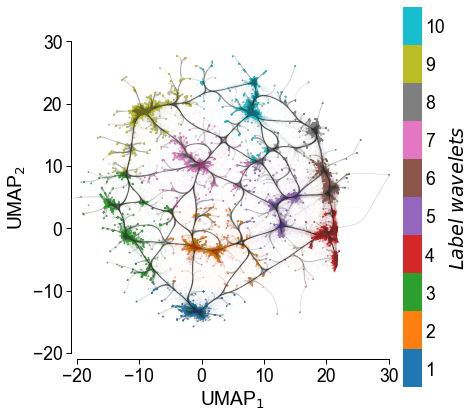

In [5]:
color = label_wav_all[::config.EDG_SUBSAMPLE_EVERY]
label = r"$Label$ $wavelets$"
save_name = "conectividad_wav.png"
extent = list(config.WAT_EMB_WAV_EDG) * 2
dpi = 600
width = 7 * dpi
height = 7 * dpi
ax = hammer_connectivity(
    edges=edg_wav,
    extent=extent,
    dpi=dpi,
    width=width,
    height=height,
)
xmin = extent[0]
xmax = extent[1]
ymin = extent[2]
ymax = extent[3]
ax.scatter(
    *out_wav_all[::config.EDG_SUBSAMPLE_EVERY].T,
    s=1,
    alpha=0.01,
    c=color,
    cmap="tab10",
    zorder=15,
)
plt.xlabel(r"UMAP$_1$")
plt.ylabel(r"UMAP$_2$")
norm = Normalize(vmin=0.5, vmax=10.5)
mappable = ScalarMappable(norm=norm, cmap="tab10")
mappable.set_array(color)
cbar = plt.colorbar(mappable, ax=plt.gca(), pad=0.02)
cbar.set_label(label=label)
cbar.set_ticks(range(1, 11))
cbar.set_ticklabels(range(1, 11))
cbar.ax.set_frame_on(False)
cbar.ax.tick_params(axis="both", which="both", length=0)
sns.despine(trim=True)
plt.gca().tick_params(bottom=True, left=True)
plt.axis("scaled")
plt.savefig(config_dodo.FIG_PATH / "Embeddings/Colors/Wavelets" / save_name, bbox_inches="tight", dpi=600)
plt.show()
plt.close()

In [12]:
def get_single_entropy_hist_labels(key, label_key, data, hist_bins):
    m, d, t = key
    trial_labels = data.query(r"mouse==@m & day==@d & trial==@t")[label_key].to_numpy()
    hist_trial_labels = np.histogram(a=trial_labels, bins=hist_bins)[0] / len(
        trial_labels
    )
    entropy_labels = entropy(hist_trial_labels)
    return entropy_labels, hist_trial_labels

tmax = 10000
mask = seq_data_wav.local_idx <= tmax
short_data = []
hist_bins = np.arange(0.5, 11.5)
for key in config_dodo.KEY_LIST:
    ent, p = get_single_entropy_hist_labels(
        key, "label_wav", seq_data_wav.loc[mask], hist_bins
    )
    p = p * 100
    dat = {"mouse": key[0], "day": key[1], "trial": key[2], "entropy_wav": ent}
    dat.update(dict(zip([f"p{i + 1}_wav" for i in range(len(p))], p)))
    short_data.append(dat)
short_data = pd.DataFrame(short_data)
mouse_performance_dict = {m: "lp" for m in config_dodo.LP_MOUSE_LIST}
mouse_performance_dict.update({m: "hp" for m in config_dodo.HP_MOUSE_LIST})
short_data["performance"] = short_data["mouse"].map(mouse_performance_dict)

hist_wav_all = np.histogram(a=seq_data_wav["label_wav"], bins=hist_bins)[0] / len(seq_data_wav)
ent_wav_all = entropy(hist_wav_all)

ANOVA
hp 0.002719753654492553
lp 2.5549477000129275e-05
Paired t-test
D1 0.27250878188508193
D2 0.05465685459343232
D3 0.10150221015398786
D4 0.03493887934845782
D5 0.09735480509486731


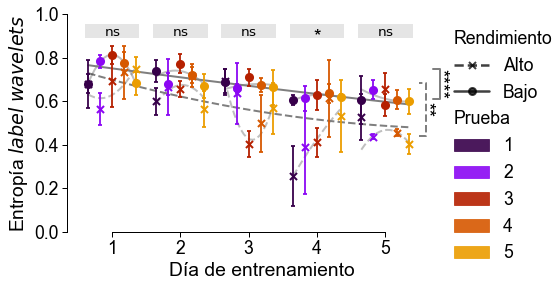

In [16]:
from scipy.stats import f_oneway, ttest_rel
from scipy.optimize import curve_fit

def pvalue_to_stars(pvalue):
    """Format pvalue into stars or ns"""
    text = ""
    if pvalue <= 0.05:
        text += "*"
        if pvalue <= 0.01:
            text += "*"
            if pvalue <= 0.001:
                text += "*"
                if pvalue <= 0.0001:
                    text += "*"
    else:
        text = r"$^{\mathrm{ns}}$"
    return text

def plot_pvalue_vertical(ax, pvalue, x, ylims, w, ls, lw, c, alpha):
    """annotate pvalue"""
    text = pvalue_to_stars(pvalue)
    ymin, ymax = ylims
    ax.plot([x, x + w, x + w, x], [ymin, ymin, ymax, ymax], ls=ls, lw=lw, c=c, alpha=alpha)
    ax.annotate(text=text, xy=(x + w, 0.5 * (ymin + ymax)), zorder=10, ha="center", va="center", rotation=-90)

def plot_pvalue_horizontal(ax, pvalue, y, xlims, h, c, alpha):
    """annotate pvalue"""
    text = pvalue_to_stars(pvalue)
    xmin, xmax = xlims
    rect = mpatches.Rectangle((xmin, y), xmax - xmin, h, linewidth=0.0, edgecolor="none", facecolor=c, alpha=alpha)
    ax.add_patch(rect)
    ax.annotate(text=text, xy=(0.5 * (xmin + xmax), y), zorder=10, ha="center", va="center")

def my_poly(x, *p):
    """my polynomial function, change order of parameters to a more natural one"""
    return np.polyval(p[::-1], x)

def my_poly_plot(x, *p):
    """my polynomial function to plot, change order of parameters to a more natural one"""
    return np.polyval(p[::-1], x)

def fit_poly_plot(deg, t, mu, sigma):
    """fit a deg order polynomial to t_ref mu_ref"""
    popt, _ = curve_fit(my_poly, t, mu, sigma=sigma, absolute_sigma=True, p0=[1] * (deg + 1))
    return popt

box_width = 0.8
delta_pos_dias = 1.0
pos_dias = np.arange(1, 6) * delta_pos_dias
delta_pos_trials = 0.175
pos_trials = np.arange(-2, 3) * delta_pos_trials
pos = [pos_d + pos_t for pos_d, pos_t in product(pos_dias, pos_trials)]
color_trials = plt.get_cmap("gnuplot")([0.05, 0.3, 0.5, 0.7, 0.85], len(config_dodo.DAY_LIST))
ls_perf = {"lp": "-", "hp": "--"}
marker_perf = {"lp": "o", "hp": "x"}

metricas_grupos_intertrial = short_data.groupby(["performance", "day", "trial"])
mean = metricas_grupos_intertrial.mean()
error = metricas_grupos_intertrial.sem()
metricas_grupos_interdia = short_data.groupby(["performance", "day"])
mean_interdia = metricas_grupos_interdia.mean()
error_interdia = metricas_grupos_interdia.sem()
(config_dodo.FIG_PATH / "Latencia").mkdir(parents=True, exist_ok=True)

fig = plt.figure(figsize=(7, 4))
for t, p in product(config_dodo.TRIAL_LIST, ["lp", "hp"]):
    i = t - 1
    values = mean.query("trial == @t and performance == @p")["entropy_wav"].values / ent_wav_all
    bars = error.query("trial == @t and performance == @p")["entropy_wav"].values / ent_wav_all
    plt.scatter(
        x=pos[i::5], y=values,
        marker=marker_perf[p], color=color_trials[i], s=50, linewidths=2, alpha=1.0, zorder=10
    )
    plt.errorbar(
        x=pos[i::5], y=values, yerr=bars,
        color="none", ecolor=color_trials[i], capsize=2, elinewidth=2, capthick=2, alpha=0.9, zorder=10
    )
for p in ["lp", "hp"]:
    values_interdia = mean_interdia.query("performance == @p")["entropy_wav"].values / ent_wav_all
    bars_interdia = error_interdia.query("performance == @p")["entropy_wav"].values / ent_wav_all
    popt = fit_poly_plot(deg=2, t=pos_dias, mu=values_interdia, sigma=bars_interdia)
    plt.plot(pos, my_poly_plot(pos, *popt), color="k", linewidth=2, alpha=0.5, ls=ls_perf[p], zorder=0)
    for d in config_dodo.DAY_LIST:
        values = mean.query("day == @d and performance == @p")["entropy_wav"].values / ent_wav_all
        bars = error.query("day == @d and performance == @p")["entropy_wav"].values / ent_wav_all
        pos_d = d + pos_trials
        popt = fit_poly_plot(deg=2, t=pos_d, mu=values, sigma=bars)
        pos_d = np.linspace(pos_d[0], pos_d[-1], 16)
        plt.plot(pos_d, my_poly_plot(pos_d, *popt), color="0.5", linewidth=2, alpha=0.5, ls=ls_perf[p], zorder=0)

"""Perform one way ANOVA over lat using day and trial as categories and latency as dependent variable"""
ax = plt.gca()
xlims = ax.get_xlim()
ylims = ax.get_ylim()
print("ANOVA")
dx = 0.0
for p in ["hp", "lp"]:
    stat, pvalue = f_oneway(*[short_data.query("day == @d and performance == @p")["entropy_wav"].values / ent_wav_all for d in config_dodo.DAY_LIST])
    # stat, pvalue = f_oneway(*[short_data.query("day == @d and trial == @t and performance == @p")["entropy_wav"].values / ent_wav_all for (d, t) in product(config_dodo.DAY_LIST, config_dodo.TRIAL_LIST)])
    plot_pvalue_vertical(
        ax=ax, pvalue=pvalue, x=5.5 + dx,
        ylims=(mean_interdia.query("performance == @p")["entropy_wav"].min() / ent_wav_all, mean_interdia.query("performance == @p")["entropy_wav"].max()  / ent_wav_all),
        w=0.1, ls=ls_perf[p], lw=2, c="k", alpha=0.5,
    )
    dx += 0.2
    print(p, pvalue)
"""Perform paired t-test over lat for each day, pairing the means from lp and hp for each trial"""
print("Paired t-test")
for d in config_dodo.DAY_LIST:
    stat, pvalue = ttest_rel(*[mean.query("day == @d and performance == @p")["entropy_wav"].values / ent_wav_all for p in ["lp", "hp"]])
    plot_pvalue_horizontal(
        ax=ax, pvalue=pvalue, y=ylims[1],
        xlims=(d - 0.4, d + 0.4),
        h=(ylims[1] - ylims[0]) * 0.075, c="0.5", alpha=0.2,
    )
    print(f"D{d}", pvalue)

plt.xticks(pos_dias, config_dodo.DAY_LIST)
plt.xlabel("Día de entrenamiento")
plt.ylabel(r"Entropía $label$ $wavelet$")
handles = []
labels = []
title_1 = "Rendimiento"
title_2 = "Prueba"
handles += [Line2D([], [], color="none")]
labels += [title_1]
handles += [Line2D([], [], marker=marker_perf[p], markersize=7, markeredgewidth=2, lw=2.5, ls=ls_perf[p], c="k", alpha=0.75) for p in ["hp", "lp"]]
labels += ["Alto", "Bajo"]
handles += [Line2D([], [], color="none")]
labels += [title_2]
handles += [mpatches.Patch(color=c, alpha=0.9) for c in color_trials]
labels += [str(t) for t in config_dodo.TRIAL_LIST]
leg = plt.legend(handles=handles, labels=labels, loc="upper left", bbox_to_anchor=(0.95, 1), frameon=False)
for item, label in zip(leg.legendHandles, leg.texts):
    if label._text in [title_1, title_2]:
        width = item.get_window_extent(fig.canvas.get_renderer()).width
        label.set_ha("left")
        label.set_position((-1.4 * width, 0.0))
leg._legend_handle_box.width = 90.0
plt.ylim(0, 1)
sns.despine(trim=True)
plt.savefig(config_dodo.FIG_PATH / "Metrics" / "wav/entropia_wav.pdf", bbox_inches="tight")
plt.show()
plt.close()

In [23]:
(config_dodo.FIG_PATH / "Metrics" / "wav").mkdir(parents=True, exist_ok=True)
from scipy.stats import f_oneway, ttest_rel
from scipy.optimize import curve_fit

p_keys = [f"p{i + 1}_wav" for i in range(10)]

def pvalue_to_stars(pvalue):
    """Format pvalue into stars or ns"""
    text = ""
    if pvalue <= 0.05:
        text += "*"
        if pvalue <= 0.01:
            text += "*"
            if pvalue <= 0.001:
                text += "*"
                if pvalue <= 0.0001:
                    text += "*"
    else:
        text = r"$^{\mathrm{ns}}$"
    return text

def plot_pvalue_vertical(ax, pvalue, x, ylims, w, ls, lw, c, alpha):
    """annotate pvalue"""
    text = pvalue_to_stars(pvalue)
    ymin, ymax = ylims
    ax.plot([x, x + w, x + w, x], [ymin, ymin, ymax, ymax], ls=ls, lw=lw, c=c, alpha=alpha)
    ax.annotate(text=text, xy=(x + w, 0.5 * (ymin + ymax)), zorder=10, ha="center", va="center", rotation=-90)

def plot_pvalue_horizontal(ax, pvalue, y, xlims, h, c, alpha):
    """annotate pvalue"""
    text = pvalue_to_stars(pvalue)
    xmin, xmax = xlims
    rect = mpatches.Rectangle((xmin, y), xmax - xmin, h, linewidth=0.0, edgecolor="none", facecolor=c, alpha=alpha)
    ax.add_patch(rect)
    ax.annotate(text=text, xy=(0.5 * (xmin + xmax), y), zorder=10, ha="center", va="center")

def my_poly(x, *p):
    """my polynomial function, change order of parameters to a more natural one"""
    return np.polyval(p[::-1], x)

def my_poly_plot(x, *p):
    """my polynomial function to plot, change order of parameters to a more natural one"""
    return np.polyval(p[::-1], x)

def fit_poly_plot(deg, t, mu, sigma):
    """fit a deg order polynomial to t_ref mu_ref"""
    popt, _ = curve_fit(my_poly, t, mu, sigma=sigma, absolute_sigma=True, p0=[1] * (deg + 1))
    return popt

box_width = 0.8
delta_pos_dias = 1.0
pos_dias = np.arange(1, 6) * delta_pos_dias
delta_pos_trials = 0.175
pos_trials = np.arange(-2, 3) * delta_pos_trials
pos = [pos_d + pos_t for pos_d, pos_t in product(pos_dias, pos_trials)]
# color_trials = plt.get_cmap("tab10")(np.tile(np.linspace(0, 1, 10)[:len(config_dodo.TRIAL_LIST)], len(config_dodo.DAY_LIST)))
color_trials = plt.get_cmap("gnuplot")([0.05, 0.3, 0.5, 0.7, 0.85], len(config_dodo.DAY_LIST))
ls_perf = {"lp": "-", "hp": "--"}
marker_perf = {"lp": "o", "hp": "x"}

metricas_grupos_intertrial = short_data.groupby(["performance", "day", "trial"])
mean = metricas_grupos_intertrial.mean()
error = metricas_grupos_intertrial.sem()
metricas_grupos_interdia = short_data.groupby(["performance", "day"])
mean_interdia = metricas_grupos_interdia.mean()
error_interdia = metricas_grupos_interdia.sem()
(config_dodo.FIG_PATH / "Latencia").mkdir(parents=True, exist_ok=True)

for l, p_key in enumerate(p_keys):
    fig = plt.figure(figsize=(7, 3.75))
    for t, p in product(config_dodo.TRIAL_LIST, ["lp", "hp"]):
        i = t - 1
        values = mean.query("trial == @t and performance == @p")[p_key].values
        bars = error.query("trial == @t and performance == @p")[p_key].values
        plt.scatter(
            x=pos[i::5], y=values,
            marker=marker_perf[p], color=color_trials[i], s=50, linewidths=2, alpha=1.0, zorder=10
        )
        plt.errorbar(
            x=pos[i::5], y=values, yerr=bars,
            color="none", ecolor=color_trials[i], capsize=2, elinewidth=2, capthick=2, alpha=0.9, zorder=10
        )
    for p in ["lp", "hp"]:
        values_interdia = mean_interdia.query("performance == @p")[p_key].values
        bars_interdia = error_interdia.query("performance == @p")[p_key].values
        popt = fit_poly_plot(deg=2, t=pos_dias, mu=values_interdia, sigma=bars_interdia + 1e-6)
        plt.plot(pos, my_poly_plot(pos, *popt), color="k", linewidth=2, alpha=0.5, ls=ls_perf[p], zorder=0)
        for d in config_dodo.DAY_LIST:
            values = mean.query("day == @d and performance == @p")[p_key].values
            bars = error.query("day == @d and performance == @p")[p_key].values
            pos_d = d + pos_trials
            popt = fit_poly_plot(deg=2, t=pos_d, mu=values, sigma=bars + 1e-6)
            pos_d = np.linspace(pos_d[0], pos_d[-1], 16)
            plt.plot(pos_d, my_poly_plot(pos_d, *popt), color="0.5", linewidth=2, alpha=0.5, ls=ls_perf[p], zorder=0)

    """Perform one way ANOVA over lat using day and trial as categories and latency as dependent variable"""
    ax = plt.gca()
    xlims = ax.get_xlim()
    ylims = ax.get_ylim()
    dx = 0.0
    for p in ["hp", "lp"]:
        # stat, pvalue = f_oneway(*[short_data.query("day == @d and trial == @t and performance == @p")[p_key].values for (d, t) in product(config_dodo.DAY_LIST, config_dodo.TRIAL_LIST)])
        stat, pvalue = f_oneway(*[short_data.query("day == @d and performance == @p")[p_key].values for d in config_dodo.DAY_LIST])
        plot_pvalue_vertical(
            ax=ax, pvalue=pvalue, x=5.5 + dx,
            ylims=(mean_interdia.query("performance == @p")[p_key].min(), mean_interdia.query("performance == @p")[p_key].max() ),
            w=0.1, ls=ls_perf[p], lw=2, c="k", alpha=0.5,
        )
        dx += 0.2
    """Perform paired t-test over lat for each day, pairing the means from lp and hp for each trial"""
    for d in config_dodo.DAY_LIST:
        stat, pvalue = ttest_rel(*[mean.query("day == @d and performance == @p")[p_key].values for p in ["lp", "hp"]])
        plot_pvalue_horizontal(
            ax=ax, pvalue=pvalue, y=ylims[1],
            xlims=(d - 0.4, d + 0.4),
            h=(ylims[1] - ylims[0]) * 0.075, c="0.5", alpha=0.2,
        )

    # plt.xticks(pos_dias, config_dodo.DAY_LIST)
    # plt.xlabel("Día de entrenamiento")
    # plt.ylabel(r"Probabilidad $label$" f" {l + 1}\n" + r"$wavelets$ (%)")
    # handles = []
    # labels = []
    # title_1 = "Rendimiento"
    # title_2 = "Prueba"
    # handles += [Line2D([], [], color="none")]
    # labels += [title_1]
    # handles += [Line2D([], [], marker=marker_perf[p], markersize=7, markeredgewidth=2, lw=2.5, ls=ls_perf[p], c="k", alpha=0.75) for p in ["hp", "lp"]]
    # labels += ["Alto", "Bajo"]
    # handles += [Line2D([], [], color="none")]
    # labels += [title_2]
    # handles += [mpatches.Patch(color=c, alpha=0.9) for c in color_trials]
    # labels += [str(t) for t in config_dodo.TRIAL_LIST]
    # leg = plt.legend(handles=handles, labels=labels, loc="upper left", bbox_to_anchor=(0.95, 1), frameon=False)
    # for item, label in zip(leg.legendHandles, leg.texts):
    #     if label._text in [title_1, title_2]:
    #         width = item.get_window_extent(fig.canvas.get_renderer()).width
    #         label.set_ha("left")
    #         label.set_position((-1.4 * width, 0.0))
    # leg._legend_handle_box.width = 90.0
    ylims = ax.get_ylim()
    dy = ylims[1] * 0.05
    plt.ylim(-dy, ylims[1])
    sns.despine(trim=True)
    """grid plot subfigure"""
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.spines["bottom"].set_visible(False)
    plt.ylabel(r"$Label$" + f" {l + 1}")
    plt.savefig(config_dodo.FIG_PATH / "Metrics" / f"wav/{p_key}.pdf", bbox_inches="tight")
    # plt.show()
    plt.close()

/usr/local/lib/python3.8/dist-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
